# Breathing phase extraction.
Proceeds in 2 stages.

1. Period is determined for quasiperiodic breathing sound sample. Two-period fragment is taken arbitrarily, it's phase being imposed linearly in time. 

2. Two-period fragment is dtw-correlated with last signal values of one-period length. Best coincidence points are marked with phase values from corresponding two-period fragment points.

In [2]:
import python_speech_features as psf
import librosa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# MFCC PARAMS
hop_length = 64
n_fft = 256
f_low_pass = 5000
n_mfcc=10
f_sampling = 8000

In [4]:
# FILE WITH QUASIPERIODIC BREATHING SAMPLE
fname = '2018_05_05_11_18_17.wav'
signal, f_sampling  = librosa.load(fname)

In [5]:
# AUTOREGRESSION

#import statsmodels
#from statsmodels.tsa import ar_model

#ARM = ar_model.AR(signal)
#ARM.fit(maxlag=3)
#ARM.X
from audiolazy.lazy_lpc import lpc
look_back=50

win_len = 2000 
j=0
signal_fragments = []
while j< len(signal):        
    signal_fragments.append(signal[j:(j+win_len)]) 
    j+=win_len
    
LPCs = []
for fragment in signal_fragments:
    AR_factors_dict = lpc.auto_correlation(fragment,look_back).numdict
    LPCs.append([AR_factors_dict[j] for j in range(1,look_back+1)])

In [18]:
from sklearn.mixture import GaussianMixture

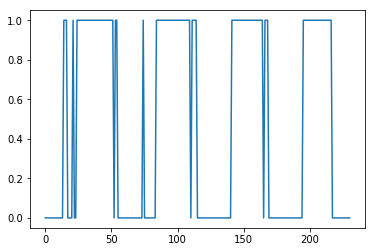

In [29]:
GMM_ = GaussianMixture(n_components=2)
GMM_.fit(LPCs)
plt.plot(GMM_.predict(LPCs))

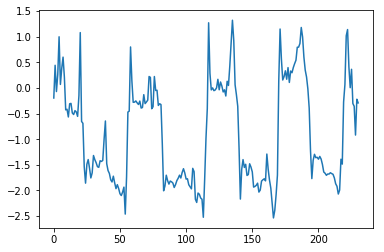

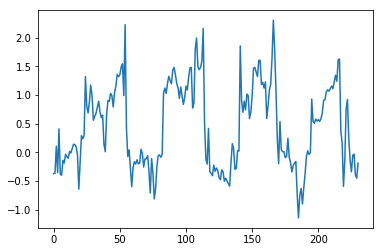

In [6]:
###### plt.figure()
plt.plot(np.array(LPCs)[:,0])

plt.figure()
plt.plot(np.array(LPCs)[:,1])


In [7]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
LPCs_scaled = SS.fit_transform(LPCs)

In [9]:
from sklearn.manifold import LocallyLinearEmbedding
LLE = LocallyLinearEmbedding(n_components=10)
#LLE.fit(np.array(LPCs))
ManifoldCoords = LLE.fit_transform(LPCs_scaled)
LLE.reconstruction_error_

0.06600677243031818

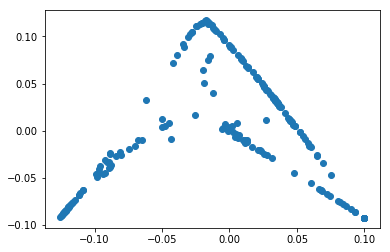

In [10]:
#plt.hist2d(ManifoldCoords[:,0],ManifoldCoords[:,1])
plt.plot(ManifoldCoords[:,0],ManifoldCoords[:,1],'o')

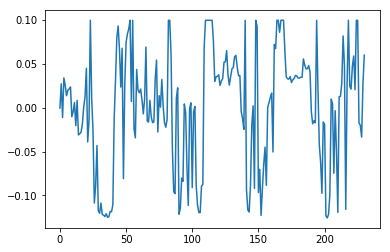

In [11]:
plt.plot(ManifoldCoords[:,0])

In [12]:
from sklearn import metrics
metrics.euclidean_distances(ManifoldCoords[:2,:])


array([[0.        , 0.15577675],
       [0.15577675, 0.        ]])

5.274928631526121

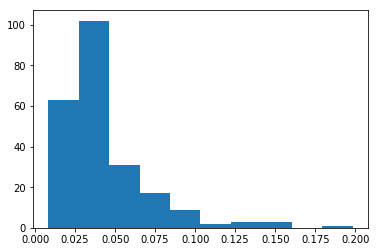

In [13]:
#METRICS FOR POINTS UNIFORMITY DISTRIBUTION 
from scipy.stats import entropy
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(ManifoldCoords)
distances, indices = nbrs.kneighbors(ManifoldCoords)
np.mean(distances[:,1:], axis=1)


plt.hist(np.mean(distances[:,1:], axis=1)) 
entropy(np.mean(distances[:,1:], axis=1))

In [ ]:
entropy([1, 1.1, 2, 2])- entropy([1, 1.2, 2, 2])

/home/x/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


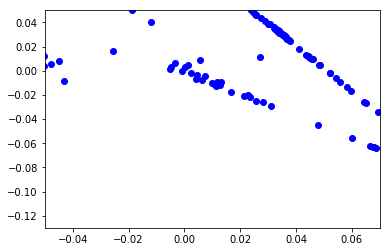

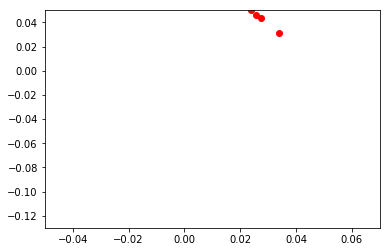

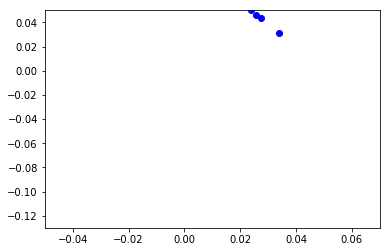

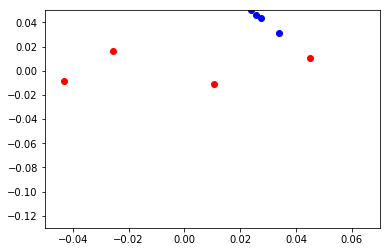

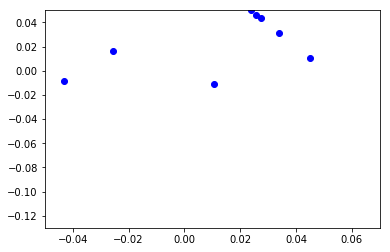

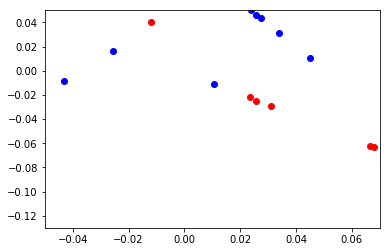

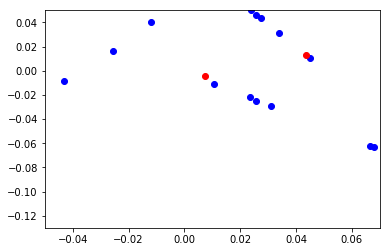

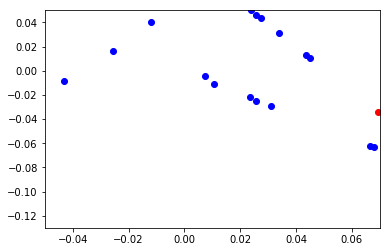

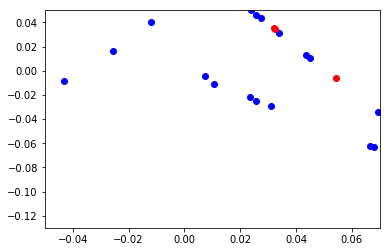

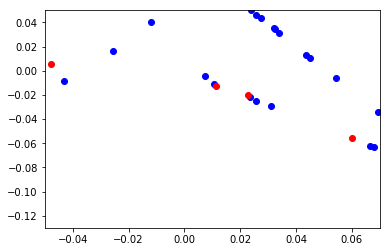

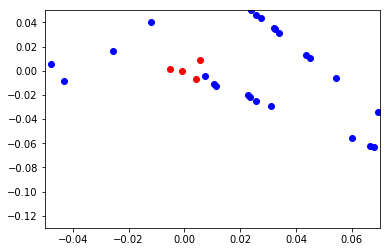

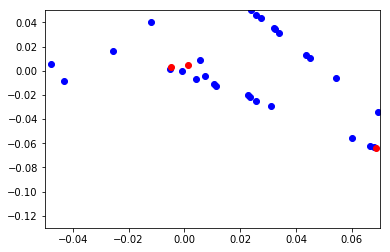

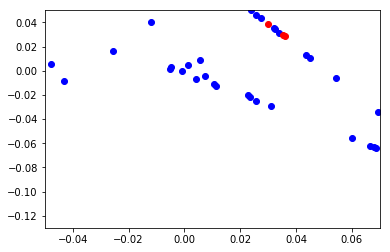

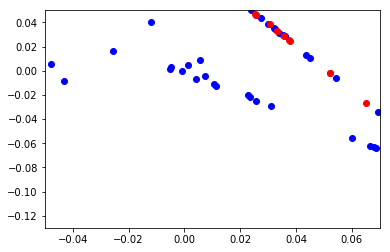

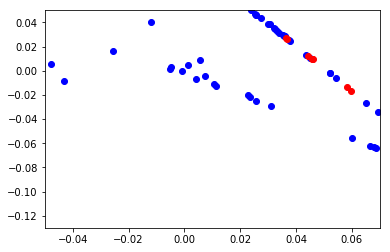

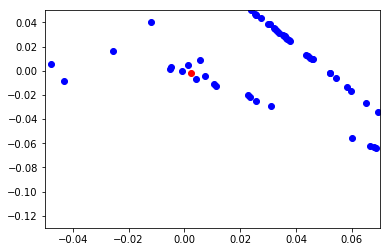

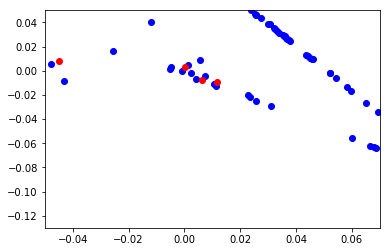

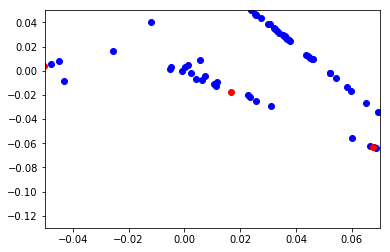

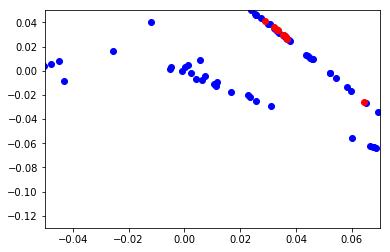

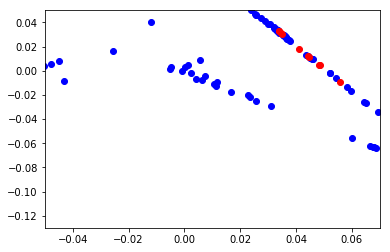

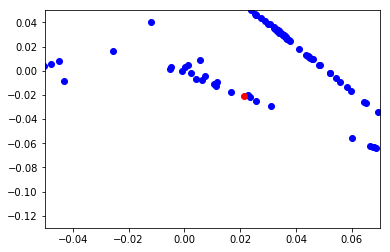

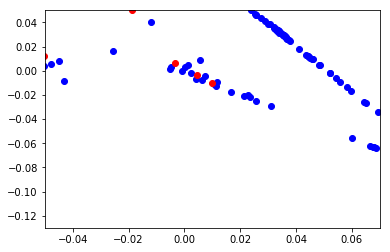

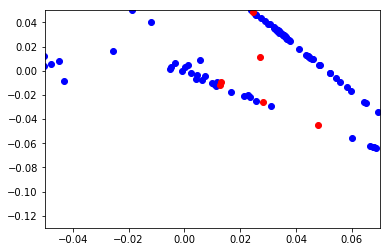

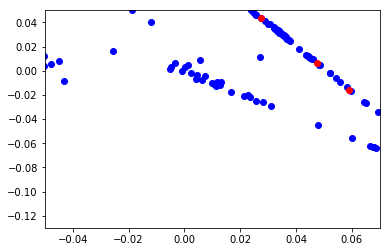

In [16]:
for j in range(0,ManifoldCoords.shape[0],10 ):
    plt.figure()
    plt.xlim(-0.05, 0.07)
    plt.ylim(-0.13, 0.05)
    plt.plot(ManifoldCoords[:(j-10),0],ManifoldCoords[:(j-10),1],'o', color='blue')
    plt.plot(ManifoldCoords[(j-10):j,0],ManifoldCoords[(j-10):j,1],'o', color='red')
#plt.plot('0', (ManifoldCoords[0,0],ManifoldCoords[0,1] ))
#plt.annotate('1', (ManifoldCoords[1,0],ManifoldCoords[1,1] ))

AttributeError: 'list' object has no attribute 'annotate'

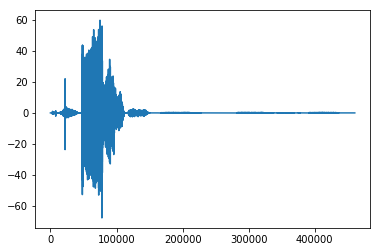

In [8]:


signal[0:150000] = 16*signal[0:150000] # just to see how amplitude changes 
                                       # signal representation (we were looking for 
                                       # those unchangeable ones)

plt.plot(signal)

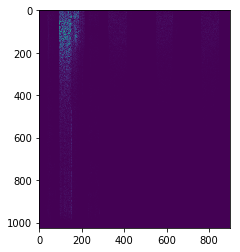

In [6]:
# spec_mtx = abs(librosa.spectrum.stft(signal))
# plt.imshow(spec_mtx)

In [9]:
# norm_vec = abs(spec_mtx).sum(axis=0)
# spec_mtx = spec_mtx.dot(np.diag(norm_vec**(-1)))

# spec_mtx

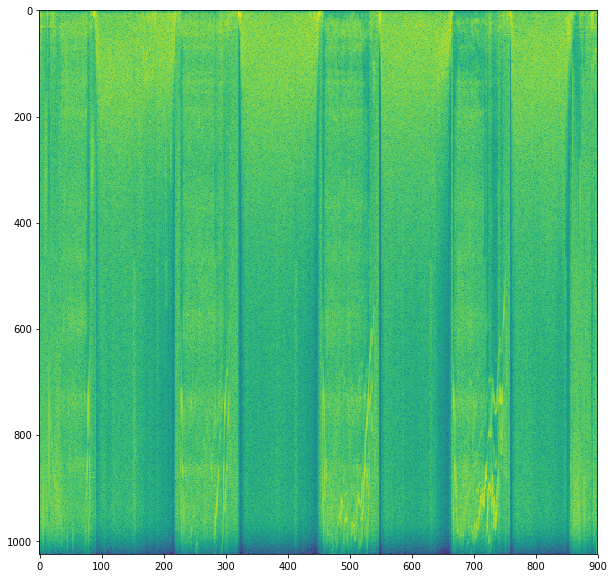

In [11]:
# plt.figure(figsize=(10,10))
# plt.imshow(np.log(spec_mtx[:,:]),aspect = 'auto')

In [12]:
mfccs = psf.mfcc(signal, appendEnergy=True, lowfreq=100, ceplifter=0, preemph=0)
#mfccs = librosa.feature.mfcc(y=signal)

_Choosing signal representation which is:_

-- amplitude independent;

-- discerns phases clearly;

This is mfcc[1] (not mfcc[0]!!!)


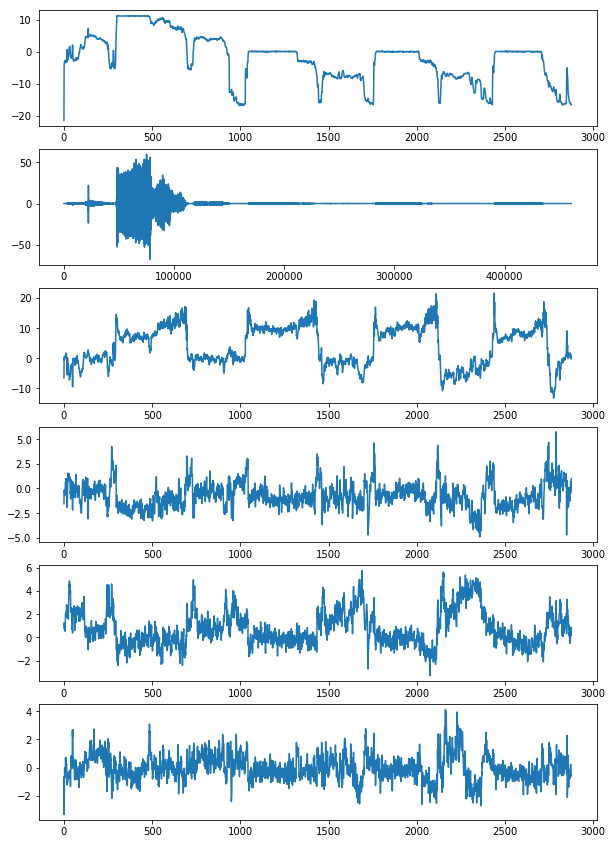

In [13]:
plt.figure(figsize=(10,20))
plt.subplot(811)
plt.plot(mfccs[:,0])
plt.subplot(812)
plt.plot(signal)
plt.subplot(813)
plt.plot(mfccs[:,1])
plt.subplot(814)
plt.plot(mfccs[:,3])
plt.subplot(815)
plt.plot(mfccs[:,4])
plt.subplot(816)
plt.plot(mfccs[:,5])

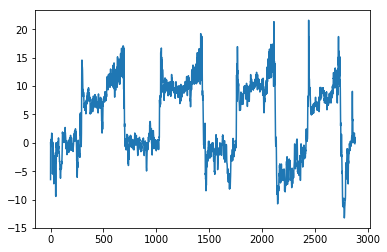

In [14]:
mfccs_1st = mfccs[:,1]
plt.plot(mfccs_1st)

_mfcc[1] has clearly distinct period_

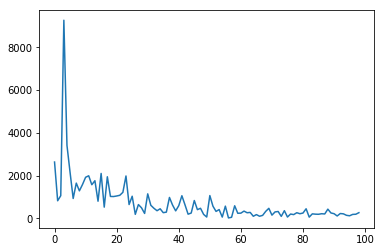

In [15]:
plt.plot(np.abs(np.fft.fft(mfccs_1st))[1:100])


_Period value_

In [19]:
Nfft = mfccs_1st.shape[0] 
fft = np.abs(np.fft.fft(mfccs_1st))[1:100]
P = Nfft/(np.argmax(fft)+1)
P=int(P)

_Step matrix determination_

In [16]:
N_step_max = int(5)
step_sizes_sigma= np.empty([N_step_max**2, 2], dtype=int)

cnt=0
for j in range(N_step_max):
    for k in range(N_step_max):        
            step_sizes_sigma[cnt,0] = j+1        
            step_sizes_sigma[cnt,1] = k+1
            cnt+=1

        
    
    
# for j in range(N_step_max):
#     step_sizes_sigma[j,0] = int(0)
#     step_sizes_sigma[j,1] = int(j+1)
#     step_sizes_sigma[j+N_step_max,0] = int(j+1)
#     step_sizes_sigma[j+N_step_max,1] = int(0)
#     step_sizes_sigma[j+2*N_step_max,0] = int(j+1)
#     step_sizes_sigma[j+2*N_step_max,1] = int(j+1)
    
    

step_sizes_sigma

array([[1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [2, 5],
       [3, 1],
       [3, 2],
       [3, 3],
       [3, 4],
       [3, 5],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4],
       [4, 5],
       [5, 1],
       [5, 2],
       [5, 3],
       [5, 4],
       [5, 5]])

_Two periods fragment phase initialization_

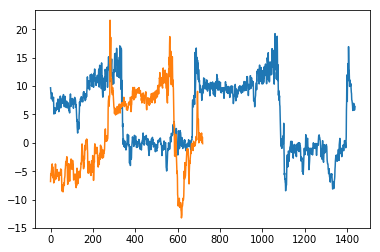

In [20]:
TwoPeriodsFragment = mfccs_1st[int(.5*P):int(2.5*P)] 
TwoPeriodsFragment_phase = np.concatenate([np.arange(0,2*np.pi, 2*np.pi/int(P) ), np.arange(0,2*np.pi, 2*np.pi/int(P) )])
NewFragment = mfccs_1st[-int(P):]

plt.plot(TwoPeriodsFragment)
plt.plot(NewFragment)

_Phase for 1 period long fragment at the end _

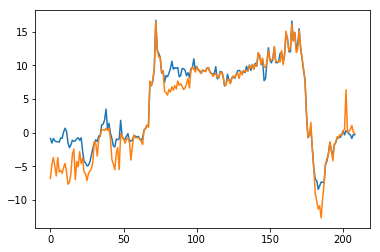

In [21]:
(D, path) = librosa.core.dtw(TwoPeriodsFragment, NewFragment, subseq=True, step_sizes_sigma=step_sizes_sigma)
path1_rev =  list(path[:,0])
path1_rev.reverse() 
path2_rev =  list(path[:,1])
path2_rev.reverse() 

                
plt.plot(TwoPeriodsFragment[path1_rev])
plt.plot(NewFragment[path2_rev])

_phase for NewFragment points who survived dtw (pinpoints)

In [22]:
path

array([[1153,  718],
       [1151,  715],
       [1147,  710],
       [1142,  706],
       [1141,  701],
       [1140,  700],
       [1139,  695],
       [1135,  690],
       [1134,  685],
       [1133,  683],
       [1132,  679],
       [1131,  674],
       [1130,  669],
       [1129,  664],
       [1128,  661],
       [1126,  656],
       [1125,  651],
       [1124,  646],
       [1122,  641],
       [1120,  640],
       [1115,  635],
       [1114,  630],
       [1113,  625],
       [1112,  620],
       [1111,  615],
       [1110,  610],
       [1109,  605],
       [1108,  600],
       [1105,  597],
       [1103,  593],
       [1098,  591],
       [1094,  589],
       [1090,  585],
       [1085,  583],
       [1080,  581],
       [1077,  580],
       [1073,  578],
       [1069,  576],
       [1064,  575],
       [1062,  574],
       [1057,  573],
       [1052,  571],
       [1048,  569],
       [1046,  568],
       [1041,  566],
       [1037,  565],
       [1032,  561],
       [1027,

In [23]:
NewFragment_pinpoints = path2_rev
NewFragment_pinpoints_phase  = [   TwoPeriodsFragment_phase[j] for j in path1_rev   ] 

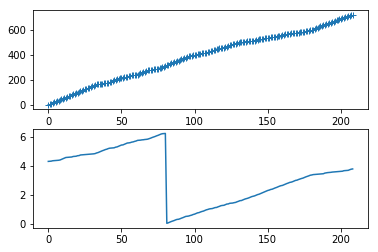

In [24]:
#plt.plot(NewFragment_pinpoints, NewFragment_pinpoints_phase,'+')
plt.subplot(211)
plt.plot(NewFragment_pinpoints,'+')
plt.subplot(212)
plt.plot(NewFragment_pinpoints_phase)

In [25]:
NewFragment_pinpoints_phase

[4.316959028854959,
 4.325697812314179,
 4.3344365957734,
 4.3606529461510615,
 4.369391729610282,
 4.378130513069503,
 4.386869296528723,
 4.395608079987944,
 4.413085646906385,
 4.456779564202487,
 4.500473481498591,
 4.544167398794693,
 4.587861316090796,
 4.596600099550017,
 4.605338883009237,
 4.614077666468458,
 4.6228164499276785,
 4.657771583764561,
 4.666510367223782,
 4.675249150683002,
 4.710204284519884,
 4.7189430679791045,
 4.762636985275208,
 4.771375768734428,
 4.780114552193648,
 4.7888533356528695,
 4.79759211911209,
 4.80633090257131,
 4.815069686030531,
 4.823808469489752,
 4.832547252948972,
 4.841286036408192,
 4.858763603326634,
 4.902457520622737,
 4.928673871000398,
 4.972367788296501,
 5.016061705592604,
 5.059755622888707,
 5.094710756725589,
 5.138404674021692,
 5.164621024399353,
 5.208314941695456,
 5.234531292073118,
 5.2432700755323385,
 5.252008858991559,
 5.26074764245078,
 5.304441559746882,
 5.321919126665324,
 5.365613043961426,
 5.4093069612575295,

In [ ]:
def getNewFragmentPhases(NewFragment, TwoPeriodsFragment,
                         TwoPeriodsFragment_phase, step_sizes_sigma):
    
    (D, path) = librosa.core.dtw(TwoPeriodsFragment, NewFragment, 
                                 subseq=True, step_sizes_sigma=step_sizes_sigma)
    path1_rev =  list(path[:,0])
    path1_rev.reverse() 
    path2_rev =  list(path[:,1])
    path2_rev.reverse() 
    NewFragment_pinpoints = path2_rev
    NewFragment_pinpoints_phase  = [   TwoPeriodsFragment_phase[j] for j in path1_rev   ] 
    
    return NewFragment_pinpoints_phase
    
    
    

## Real time implementation

In [18]:
import sounddevice as sd

ImportError: No module named 'sounddevice'

In [ ]:
s_vec1 = np.random.random_sample(size=1000)
sd.play(10*s_vec1, 8000)
s_vec2 = [100.]

In [ ]:
acc_step=100 # step for increment in signal accumulation
start_ind = 0  
y_arr=[]

while (start_ind+int(P))<len(mfccs_1st): 
    NewFragment = mfccs_1st[start_ind:(start_ind+int(P))]
    start_ind+=acc_step
    new_phase = getNewFragmentPhases(NewFragment, TwoPeriodsFragment,
                         TwoPeriodsFragment_phase, step_sizes_sigma)[-1]
    y_arr.append(new_phase)
    if (new_phase>np.pi):
        sd.play(10*s_vec1, 8000)
    else:
        sd.play(10*s_vec2, 8000)
        
    
    
    


In [ ]:
plt.plot(y_arr)

In [ ]:
%%timeit
for j in range(100):
    sd.play([1.],8000)

In [ ]:
import time
import rtmidi

midiout = rtmidi.MidiOut()
available_ports = midiout.get_ports()

if available_ports:
    midiout.open_port(0)
else:
    midiout.open_virtual_port("My virtual output")
#midiout.open_virtual_port("My virtual output")

note_on = [0x90, 60, 112] # channel 1, middle C, velocity 112
note_off = [0x80, 60, 0]
midiout.send_message(note_on)
time.sleep(1)
midiout.send_message(note_off)

#del midiout



In [ ]:
del midiout

In [ ]:
available_ports

In [ ]:
midiout.send_message([0x12, 30, 101])
time.sleep(0.5)

In [ ]:
midiout.open_virtual_port("My virtual output")

In [ ]:
??midiout.open_port